# **Identificador de cachorro e gato**

## Autor:
#### Nome: João Gabriel Elvas Ribeiro
#### Matricula: 190109599
#### Github: JoaoGElvas

## Objetivo:
#### Conseguir distinguir um cachorro de um gato.

## Preparando o ambiente: 
#### Primeiro iremos instalar o duckduckgo_search para podermos encontrar as URLS de imagens.
#### Após isso iremos instalar a biblioteca do fastai.

In [ ]:
pip install -U duckduckgo_search

In [ ]:
pip install fastai

## Obtendo as primeiras imagens 

#### Será utilizado o duckduckgo para encontrarmos as primeiras imagens

In [28]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Será utilizado o fastdownload para realizar o download de imagens.

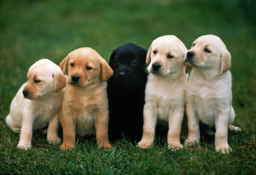

In [29]:
from fastdownload import download_url
dest = 'dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### Temos nossa primeira imagem de cachorro.

Searching for 'cat'


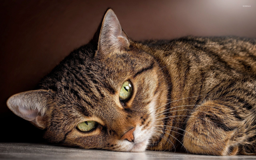

In [30]:
download_url(search_images('cat', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

#### Temos nossa primeira imagem de gato.

#### A seguri iremos utilizar o código abaixo para realizar o dowload de alguns grupos de imagens para treinamento: 
* Foto de cachorro
* Foto de cachorro no sol
* Foto de cachorro na sombra
* Foto de gato
* Foto de gato no sol
* Foto de gato na sombra

#### Obs: O comando *sleep(10)* é utilizado para gerar uma pausa entre as pesquisas, assim evitando sobrecarregar o servidor

In [8]:
searches = 'dog','cat'
path = Path('dog_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10) 
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'dog sun photo'
Searching for 'dog shade photo'
Searching for 'cat photo'
Searching for 'cat sun photo'
Searching for 'cat shade photo'


In [31]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

#### Nessa etapa acima foi verificado se as imagens foram baixadas corretamente, as que apresentarem problemas serão excluídas.

#### A fim de desenvolver um modelo para realizar previsões, é preciso contar com os DataLoaders. DataLoaders são objetos que têm um conjunto de treinamento (imagens utilizadas para construir o modelo) e um conjunto de validação (imagens empregadas para avaliar a acurácia do modelo).

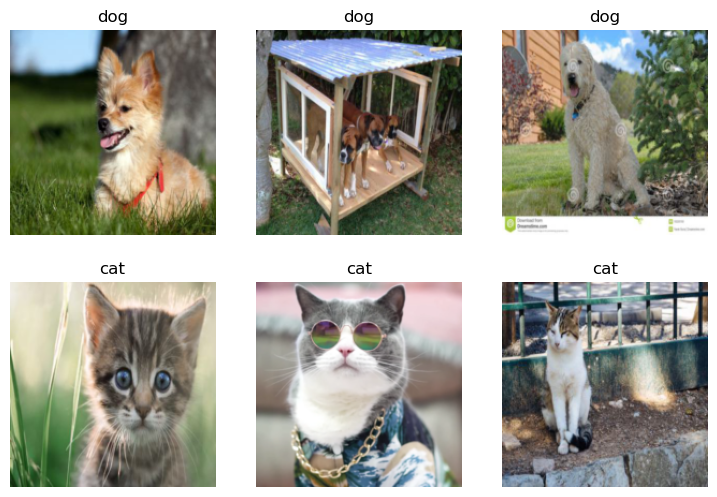

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

#### Parâmetros utilizados:

##### blocks: Como estamos utilizando imagens como inputs é neccesario utilizar o ImageBlocks. Já nossos outputs são categorias, rótulos, nesse caso cachorros e gatos.

##### get-items: A função get_image_files é utilizada para encontrarmos os nossos inputs.

##### splitter: Com a finalidade de treinar melhor nosso programa vamos dividir os dades em treinamento e validação. O comando splitter tem essa função. Neste caso, estamos dividindo em 20% para validação e não serão usados dados no treinamento.

##### get_y: Utilizado para vincular cada imagem com um rotulo correspondente à pasta em que está localizada.

##### item_tfms: Essa operação irá redimensionar as imagens para 192 pixels, utilizando o método "squish". Que seria algo com esmagar a imagem.

## Treinando o modelo

#### Abaixo iremos treinar o modelo utilizando a função 'vision_learner'. A rede neural utilizada é a 'restnet18' pois foi a recomendada pelo professor na priemeira lissão do fastai. Logo após utilizamos o 'fine_tune', que utiliza modelos pré-treinados para melhorar o modelo já criado.

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.296432,0.360810,0.181818,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.397061,0.119900,0.030303,00:17
1,0.289349,0.133225,0.060606,00:18
2,0.200430,0.129306,0.060606,00:18


## Testando o modelo

#### Agora, iremos utilizar as imagens pré-selecionadas para testar a eficácia do nosso modelo.

Isso é: dog.
Probabilidade de um dog: 99.96%


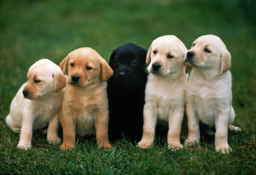

In [34]:
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"Isso é: {is_dog}.")
print(f"Probabilidade de um {is_dog}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('dog.jpg').to_thumb(256,256)

Isso é: cat.
Probabilidade de um cat: 100.00%


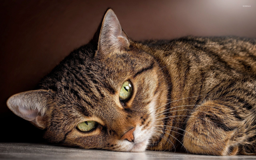

In [33]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"Isso é: {is_cat}.")
print(f"Probabilidade de um {is_cat}: {probs.sort()[0][-1]*100:.2f}%")
Image.open('cat.jpg').to_thumb(256,256)

## Conclusão
Charros e gatos, apesar de terem varias caracteristicas em comum, não são tão dificeis de distinguir. Por isso nosso programa teve uma taxa de erro de 0.060606. Mostrando que o programa erra em poucas ocasiões.

## Referência Bibliográfica
Howard, Jeremy. Practical Deep Learning for Coders, Fast.ai, 2019. Disponível em: https://course.fast.ai/Lessons/lesson1.html. Acesso em: 04 abr. 2023.